In [1]:
import numpy as np
import matplotlib.pyplot as plt
import json
import pandas as pd
import gensim
%matplotlib inline

In [2]:
## Load cleaned data
with open('./model/cleaned_df.json') as f:
    cleaned_df = json.loads(f.read())
cleaned_df = pd.DataFrame(cleaned_df)

In [4]:
cleaned_df.head()

,text,title
0,"[daniel, greenfield, shillman, journalism, fel...","[smell, hillarys, fear]"
1,"[google, pinterest, digg, linkedin, reddit, st...","[watch, exact, moment, paul, ryan, committed, ..."
2,"[us, secretary, state, john, f, kerry, said, m...","[kerry, go, paris, gesture, sympathy]"
3,"[kaydee, king, kaydeeking, november, 9, 2016, ...","[bernie, supporters, twitter, erupt, anger, dn..."
4,"[primary, day, new, york, frontrunners, hillar...","[battle, new, york, primary, matters]"


## Doc2Vec on text

In [6]:
from gensim.models.doc2vec import LabeledSentence
class LabeledTitle:
    def __init__(self, wordsLists):
        self.wordsLists = wordsLists
    def __iter__(self):
        for i, words in enumerate(self.wordsLists):
            yield LabeledSentence(words=words, tags=[i])
            
class LabeledText:
    def __init__(self, wordsLists):
        self.wordsLists = wordsLists
    def __iter__(self):
        for i, words in enumerate(self.wordsLists):
            yield LabeledSentence(words=words, tags=[i])

it_text = LabeledText(cleaned_df['text'])

In [7]:
## Train the model given the window size and the dimension of the vector
def train(window, size):
    dv_text = gensim.models.Doc2Vec(size=size, window=window, min_count=1,
                                    workers=11,alpha=0.025, min_alpha=0.025)
    dv_text.build_vocab(it_text)

    for epoch in range(5):
        dv_text.train(it_text, total_examples=dv_text.corpus_count, epochs=dv_text.iter)
        dv_text.alpha -= 0.002            # decrease the learning rate
        dv_text.min_alpha = dv_text.alpha       # fix the learning rate, no deca
        dv_text.train(it_text, total_examples=dv_text.corpus_count, epochs=dv_text.iter)
    return np.asarray(dv_text.docvecs)

To evaluate the performance of the Doc2Vec model, an assumption is made that the Doc2Vec model is good if the eigon values of the documents matrix (each row represents a document) are close to each other. That is, each dimension of the document vector can represent an independent semantic meaning. Thus, the standard deviation of the eigon values is used here as the scorer of the cross-validation process.

In [8]:
def assess(docvecs):
    _, s, _ = np.linalg.svd(docvecs)
    return np.std(docvecs)

In [9]:
params = {
    'window': [2, 3, 4, 5, 6, 7],
    'size': [100, 200, 300, 400]
}

## Use my own gridsearch algorithm

In [11]:
from itertools import product

In [14]:
result = {}
for window, size in product(params['window'], params['size']):
    docvecs = train(window, size)
    score = assess(docvecs)
    result[(window, size)] = score
    print('window: {} | size: {} | std: {}'.format(window, size, score))
    gc.collect()

D:\Anaconda3_501\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning: Call to deprecated `LabeledSentence` (Class will be removed in 4.0.0, use TaggedDocument instead).
  


window: 2 | size: 100 | std: 1.389212727546692
window: 2 | size: 200 | std: 1.1692640781402588
window: 2 | size: 300 | std: 1.027209758758545
window: 2 | size: 400 | std: 0.9105091691017151
window: 3 | size: 100 | std: 1.5845670700073242
window: 3 | size: 200 | std: 1.3133844137191772
window: 3 | size: 300 | std: 1.1476316452026367
window: 3 | size: 400 | std: 1.0154848098754883
window: 4 | size: 100 | std: 1.7485743761062622
window: 4 | size: 200 | std: 1.4314677715301514
window: 4 | size: 300 | std: 1.246058702468872
window: 4 | size: 400 | std: 1.1014412641525269
window: 5 | size: 100 | std: 1.8812700510025024
window: 5 | size: 200 | std: 1.5344595909118652
window: 5 | size: 300 | std: 1.3295661211013794
window: 5 | size: 400 | std: 1.1746494770050049
window: 6 | size: 100 | std: 1.9890187978744507
window: 6 | size: 200 | std: 1.6198973655700684
window: 6 | size: 300 | std: 1.4002981185913086
window: 6 | size: 400 | std: 1.2363835573196411
window: 7 | size: 100 | std: 2.086056470870

In [17]:
result_df = {
    'window': [],
    'size': [],
    'std': []
}
for key, val in zip(result.keys(), result.values()):
    result_df['window'].append(key[0])
    result_df['size'].append(key[1])
    result_df['std'].append(val)

In [18]:
result_df = pd.DataFrame(result_df)

In [ ]:
%%R -i result_df
library(ggplot2)
ggplot(data=result_df, aes(x=window, y=size)) + geom_point(aes(size=std, color=std))

In [11]:
import numpy as np
import pandas as pd
%load_ext rpy2.ipython

In [5]:
result = np.asarray([[2, 100, 1.389212727546692],
[2, 200, 1.1692640781402588],
[2, 300, 1.027209758758545],
[2, 400, 0.9105091691017151],
[3, 100, 1.5845670700073242],
[3, 200, 1.3133844137191772],
[3, 300, 1.1476316452026367],
[3, 400, 1.0154848098754883],
[4, 100, 1.7485743761062622],
[4, 200, 1.4314677715301514],
[4, 300, 1.246058702468872],
[4, 400, 1.1014412641525269],
[5, 100, 1.8812700510025024],
[5, 200, 1.5344595909118652],
[5, 300, 1.3295661211013794],
[5, 400, 1.1746494770050049],
[6, 100, 1.9890187978744507],
[6, 200, 1.6198973655700684],
[6, 300, 1.4002981185913086],
[6, 400, 1.2363835573196411],
[7, 100, 2.0860564708709717],
[7, 200, 1.6932164430618286],
[7, 300, 1.4631848335266113],
[7, 400, 1.2899662256240845]])

In [15]:
result_df = {
    'window': result[:, 0].tolist(),
    'size': result[:, 1].tolist(),
    'std': (result[:, 2]*5).tolist()
}
result_df = pd.DataFrame(result_df)

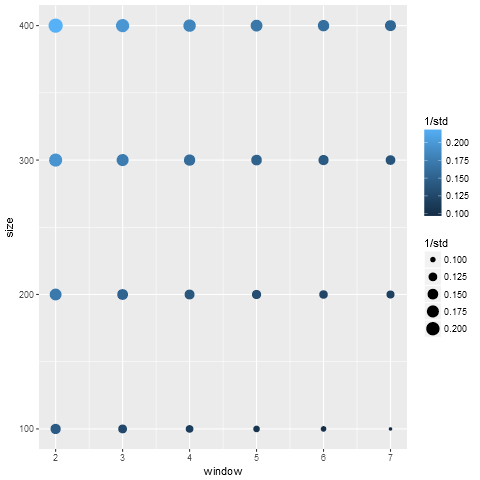

In [18]:
%%R -i result_df
library(ggplot2)
ggplot(data=result_df, aes(x=window, y=size)) + geom_point(aes(size=1/std, color=1/std))